# Creating Graph notations

First, we'll need to import the necessary libraries, and a shim for `pairwise` from `itertools` in case you don't yet have Python 3.10

In [1]:
!pipx inject jupyterlab ipywidgets IProgress tqdm collections_extended networkx pandas numpy scikit-learn scipy matplotlib

# Useful helper functions
import queue
import re
import IProgress
from itertools import tee, combinations, combinations_with_replacement, permutations, chain, repeat
from tqdm.notebook import tqdm
from collections_extended import frozenbag
from IPython.display import display, HTML

# NetworkX for graph functionality, pandas for dataframes, numpy for maths, and scikit-learn for ML
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_fscore_support
from scipy import special

# Matplotlib for visualisation
import matplotlib.pyplot as plt

⣟ installing ipywidgets  injected package ipywidgets into venv jupyterlab
done! ✨ 🌟 ✨
⢿ installing iprogress  injected package iprogress into venv jupyterlab
done! ✨ 🌟 ✨
⢿ installing tqdm  injected package tqdm into venv jupyterlab
done! ✨ 🌟 ✨
⢿ installing collections-extended  injected package collections-extended into venv jupyterlab
done! ✨ 🌟 ✨
⢿ installing networkx  injected package networkx into venv jupyterlab
done! ✨ 🌟 ✨
⣻ installing pandas  injected package pandas into venv jupyterlab
done! ✨ 🌟 ✨
⢿ installing numpy  injected package numpy into venv jupyterlab
done! ✨ 🌟 ✨
⣻ installing scikit-learn  injected package scikit-learn into venv jupyterlab
done! ✨ 🌟 ✨
⣻ installing scipy  injected package scipy into venv jupyterlab
done! ✨ 🌟 ✨
⣻ installing matplotlib  injected package matplotlib into venv jupyterlab
done! ✨ 🌟 ✨


In [2]:
# Pairwise is new in 3.10 itertools (which you may not have yet!)
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

Now let's make a multidigraph to represent our notation.

In [3]:
G = nx.MultiDiGraph()

Here's our notation (from Everist 2002).

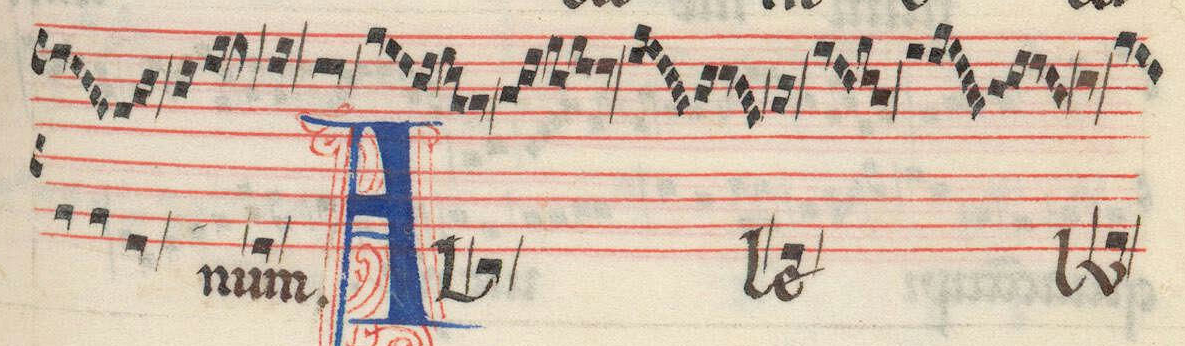

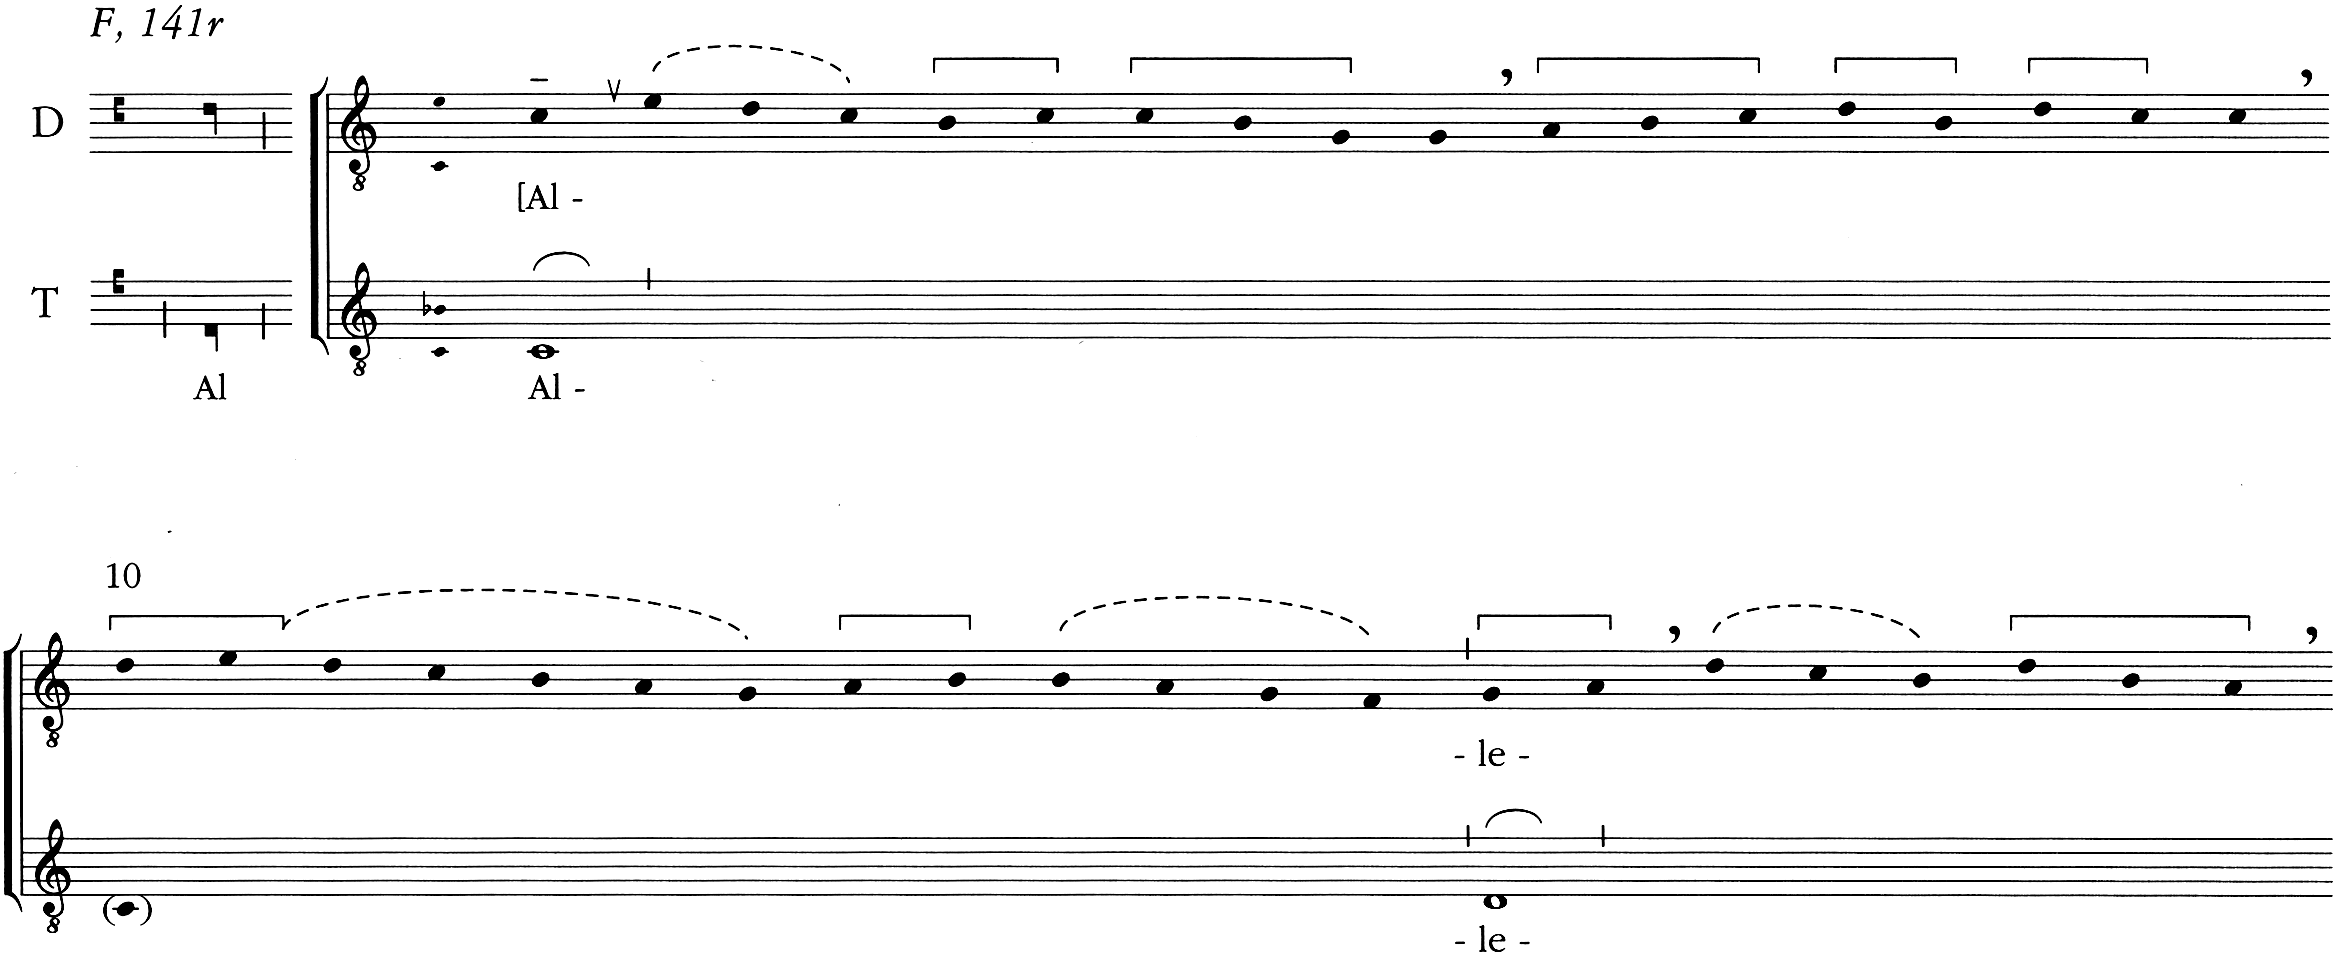

We'll represent each voice as a list for now, and also list our S links between voices as indices.

In [4]:
# Representing notes as strings, but they could be any hashable type.
v_1 = ['c', 'div.', 'e', 'd', 'c', 'B', 'c', 'c', 'B', 'G', 'G', 'div.', 'A',
       'B', 'c', 'd', 'B', 'd', 'c', 'c', 'div.', 'd', 'e', 'd', 'c', 'B',
       'A', 'G', 'A', 'B', 'B', 'A', 'G', 'F', 'div.', 'G', 'A'
      ]
v_2 = ['C', 'div.', 'div.', 'D']
# S links as tuples (v1i, v2i, weight)
S_links = [(0, 0, 1), (35, 3, 0.5), (36, 3, 0.5)]

# The N-layer is represented as the '0' layer in the MultiDiGraph,
# and the S-layer as '1'
N_KEY = 0
S_KEY = 1

Add the N layer by iterating through each voice pairwise and linking element to element in layer N.

In [5]:
_ = G.add_edges_from(
    (
        (f"v1_{a}_{i}", f"v1_{b}_{i+1}") for i, (a, b) in enumerate(
            pairwise(v_1)
        )
    ), weight=1, key=N_KEY)
_ = G.add_edges_from(
    (
        (f"v2_{a}_{i}", f"v2_{b}_{i+1}") for i, (a, b) in enumerate(
            pairwise(v_2)
        )
    ), weight=1, key=N_KEY)

Now use the indices from the S links to add our links.

In [6]:
for v1i, v2i, weight in S_links:
    G.add_edge(
        f"v1_{v_1[v1i]}_{v1i}", f"v2_{v_2[v2i]}_{v2i}",
        weight=1, key=S_KEY
    )
    G.add_edge(
        f"v2_{v_2[v2i]}_{v2i}", f"v1_{v_1[v1i]}_{v1i}",
        weight=1, key=S_KEY
    )

Define our linking function

In [7]:
def linkLayers(G, start_nodes):
    def add_edge(mode_ab, weight_ab, mode_bc, weight_bc, node_a, node_c):
        if mode_ab == N_KEY and mode_bc == N_KEY:
            mode_ac = N_KEY
        else:
            mode_ac = S_KEY
        if (
            node_a == node_c or
            G.has_edge(node_a, node_c, key=mode_ac) or
            G.has_edge(node_c, node_a, key=mode_ac)
        ):
            return False
        if mode_ab == S_KEY and mode_bc == S_KEY:
            weight_ac = (weight_ab + weight_bc) / 2
        else:
            weight_ac = (weight_ab * weight_bc) / (weight_ab + weight_bc)
        G.add_edge(node_a, node_c, key=mode_ac, weight=weight_ac)
        if mode_ac == S_KEY:
            G.add_edge(node_c, node_a, key=mode_ac, weight=weight_ac)
        return True
    nodes = set()
    link_back = set()
    pbar = tqdm(total=len(G.nodes))
    pbar.update(0)
    for node in start_nodes:
        nodes.add(node)
    pbar.update(len(start_nodes))
    try:
        while True:
            node_a = nodes.pop()
            if node_a not in link_back:
                link_back.add(node_a)
            for _, node_b, mode_ab, weight_ab in list(
                G.out_edges(node_a, data='weight', keys=True)
            ):
                if node_b not in link_back and node_b not in nodes:
                    nodes.add(node_b)
                    pbar.update(1)
                for _, node_c, mode_bc, weight_bc in list(
                    G.out_edges(node_b, data='weight', keys=True)
                ):
                    if node_c not in link_back and node_c not in nodes:
                        nodes.add(node_c)
                        pbar.update(1)
                    add_edge(
                        mode_ab, weight_ab, mode_bc, weight_bc, node_a, node_c
                    )
                    for lb_node_a in link_back:
                        for _, __, lb_mode_ab, lb_weight_ab in list(filter(
                            (lambda x: x[1] == node_b),
                            G.out_edges(lb_node_a, data='weight', keys=True)
                        )):
                            add_edge(
                                lb_mode_ab, lb_weight_ab, mode_bc, 
                                weight_bc, lb_node_a, node_c
                            )
    except KeyError:
        pass
    pbar.close()

We need to know where to begin, so first we find all the nodes that have N links coming in.  These cannot therefore be start nodes.

In [8]:
has_seq_in = {v for u, v, k in filter(
    lambda x: x[2] == N_KEY,
    G.edges(keys=True)
)}

Nodes that are not in this set have no N links coming in: they are start nodes.

In [9]:
start_nodes = set(filter(lambda x: x not in has_seq_in, G.nodes()))
start_nodes

{'v1_c_0', 'v2_C_0'}

Run our function to make a complete graph.

In [10]:
linkLayers(G, start_nodes)

  0%|          | 0/41 [00:00<?, ?it/s]

In [11]:
len(G.edges)

2312

That's a lot of edges.  Let's inspect the many edges of our new graph.

In [12]:
display(HTML(pd.DataFrame(
    (
        (u, v, ('N' if k == 0 else 'S'), d) for u, v, k, d in G.edges(
            data='weight', keys=True
        )
    ),
    columns=("Node A", "Node B", "Mode", "Weight")
).to_html()))

Let's verify that the graph is complete.

In [13]:
def is_complete_directed_graph(G):
    combs = combinations(G.nodes, 2)
    for u, v in combs:
        if not (G.has_edge(u, v) or G.has_edge(v, u)):
            raise Exception(
                f"{u} and {v} are not connected in either direction"
            )
            return False
    return True
is_complete_directed_graph(G)

True

# Creating vector representations
Great!  But our graph represents each element individually.  We want to sum together all the weights of each edge in each mode so that we know the total weight between each *type* of element.  We do this by extracting the unique elements from the nodes and making a condensed graph representation, like so.

In [14]:
condensed_G = nx.MultiDiGraph()
regex = r'v\d_([^_]+)_\d'
for u, v, mode, weight in G.edges(keys=True, data='weight'):
    match = re.search(regex, u)
    if not match:
        continue
    unique_u = match.group(1)
    match = re.search(regex, v)
    if not match:
        continue
    unique_v = match.group(1)
    if condensed_G.has_edge(unique_u, unique_v, key=mode):
        weight += condensed_G[unique_u][unique_v][mode]['weight']
    condensed_G.add_edge(unique_u, unique_v, key=mode, weight=weight)
condensed_G.nodes

NodeView(('c', 'div.', 'C', 'e', 'd', 'D', 'G', 'A', 'B', 'F'))

Let's split our graph into the two layers, N and S.

In [15]:
N_graph = condensed_G.edge_subgraph(
    (u, v, k) for u, v, k in condensed_G.edges(keys=True) if k == N_KEY
)
S_graph = condensed_G.edge_subgraph(
    (u, v, k) for u, v, k in condensed_G.edges(keys=True) if k == S_KEY
)

Extract the adjacency matrix from each, and make a dataframe from it.  Then place each side by side to make a wide vector for both the layers.

In [16]:
N_vector = pd.DataFrame(
    nx.to_numpy_array(N_graph),
    columns=(str(x) + '_N' for x in N_graph.nodes()),
    index=N_graph.nodes()
)
S_vector = pd.DataFrame(
    nx.to_numpy_array(S_graph),
    columns=(str(x) + '_S' for x in S_graph.nodes()),
    index=S_graph.nodes()
)
wide_vector = pd.concat([N_vector, S_vector], axis=1)
wide_vector

c_N    div._N  C_N       e_N       d_N       D_N       G_N  \
c     5.535636  4.025948  0.0  1.438510  4.386282  0.000000  3.684158   
div.  1.862894  1.408953  0.0  1.638528  2.662716  1.500000  1.780885   
C     0.000000  1.500000  0.0  0.000000  0.000000  0.333333  0.000000   
e     1.700111  0.281250  0.0  0.050000  2.243840  0.000000  0.748417   
d     5.521663  1.028702  0.0  1.395489  1.968651  0.000000  1.604751   
D     0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
G     1.035317  2.415433  0.0  0.160256  0.957118  0.000000  1.940107   
A     0.892857  0.795455  0.0  0.100000  0.735354  0.000000  3.080780   
B     4.648079  1.780087  0.0  0.408030  3.016804  0.000000  4.515573   
F     0.000000  1.000000  0.0  0.000000  0.000000  0.000000  0.500000   

           A_N       B_N       F_N       c_S    div._S       C_S       e_S  \
c     3.198642  7.207082  0.442122  4.256505  4.462063  1.677155  1.801081   
div.  2.390417  1.945448  0.153628  4.462063  3.071690  2.076190  1.260948   
C     0.000000  0.000000  0.000000  1.677155  2.076190  0.000000  0.376812   
e     0.843229  1.379758  0.123167  1.801081  1.260948  0.376812  0.091954   
d     2.109418  3.816863  0.334722  2.861879  1.921809  0.455177  0.714639   
D     0.000000  0.000000  0.000000  0.938419  0.850989  0.400000  0.205128   
G     3.842527  2.055608  1.251812  3.194402  2.525917  0.506926  0.806844   
A     1.686560  3.524635  0.890476  3.206101  2.306036  0.429693  0.708851   
B     4.682479  3.405259  0.892871  2.943963  2.137587  0.512083  0.820692   
F     0.333333  0.000000  0.000000  0.222980  0.156307  0.029412  0.054071   

           d_S       D_S       G_S       A_S       B_S       F_S  
c     2.861879  0.938419  3.194402  3.206101  2.943963  0.222980  
div.  1.921809  0.850989  2.525917  2.306036  2.137587  0.156307  
C     0.455177  0.400000  0.506926  0.429693  0.512083  0.029412  
e     0.714639  0.205128  0.806844  0.708851  0.820692  0.054071  
d     0.964576  0.320145  1.343729  1.244383  1.643206  0.140934  
D     0.320145  0.000000  1.208387  1.155655  0.397466  0.027027  
G     1.343729  1.208387  1.160862  2.140603  1.858591  0.122317  
A     1.244383  1.155655  2.140603  0.796751  1.991079  0.119195  
B     1.643206  0.397466  1.858591  1.991079  1.537246  0.168289  
F     0.140934  0.027027  0.122317  0.119195  0.168289  0.000000

If it is to be a stochastic matrix, then each row should sum to 1.

In [17]:
normalised_vector = wide_vector.apply(lambda row: row / row.sum(), axis=1)
normalised_vector

c_N    div._N  C_N       e_N       d_N       D_N       G_N  \
c     0.099772  0.072562  0.0  0.025927  0.079056  0.000000  0.066402   
div.  0.051585  0.039015  0.0  0.045372  0.073733  0.041536  0.049314   
C     0.000000  0.180793  0.0  0.000000  0.000000  0.040176  0.000000   
e     0.119635  0.019791  0.0  0.003518  0.157897  0.000000  0.052665   
d     0.187871  0.035001  0.0  0.047481  0.066982  0.000000  0.054601   
D     0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
G     0.036293  0.084673  0.0  0.005618  0.033552  0.000000  0.068010   
A     0.034601  0.030826  0.0  0.003875  0.028497  0.000000  0.119389   
B     0.124415  0.047648  0.0  0.010922  0.080751  0.000000  0.120868   
F     0.000000  0.347963  0.0  0.000000  0.000000  0.000000  0.173982   

           A_N       B_N       F_N       c_S    div._S       C_S       e_S  \
c     0.057651  0.129897  0.007969  0.076717  0.080422  0.030228  0.032462   
div.  0.066193  0.053871  0.004254  0.123558  0.085058  0.057491  0.034917   
C     0.000000  0.000000  0.000000  0.202145  0.250240  0.000000  0.045417   
e     0.059337  0.097092  0.008667  0.126740  0.088732  0.026516  0.006471   
d     0.071772  0.129866  0.011389  0.097374  0.065388  0.015487  0.024315   
D     0.000000  0.000000  0.000000  0.170522  0.154635  0.072685  0.037274   
G     0.134699  0.072059  0.043882  0.111979  0.088546  0.017770  0.028284   
A     0.065359  0.136590  0.034509  0.124246  0.089366  0.016652  0.027470   
B     0.125336  0.091149  0.023900  0.078801  0.057217  0.013707  0.021968   
F     0.115988  0.000000  0.000000  0.077589  0.054389  0.010234  0.018815   

           d_S       D_S       G_S       A_S       B_S       F_S  
c     0.051581  0.016914  0.057575  0.057785  0.053061  0.004019  
div.  0.053217  0.023565  0.069945  0.063856  0.059192  0.004328  
C     0.054862  0.048211  0.061099  0.051790  0.061721  0.003545  
e     0.050288  0.014435  0.056777  0.049881  0.057751  0.003805  
d     0.032819  0.010893  0.045719  0.042339  0.055909  0.004795  
D     0.058174  0.000000  0.219578  0.209996  0.072224  0.004911  
G     0.047104  0.042360  0.040694  0.075038  0.065153  0.004288  
A     0.048224  0.044785  0.082955  0.030876  0.077160  0.004619  
B     0.043984  0.010639  0.049749  0.053295  0.041148  0.004505  
F     0.049040  0.009404  0.042562  0.041475  0.058559  0.000000

The vector is very wide, so for visualisation, we'll make a PCA plot.

In [18]:
pca = PCA(n_components=2)
transformed_vector = pd.DataFrame(
    pca.fit_transform(normalised_vector),
    index=normalised_vector.index,
    columns=['PCA1', 'PCA2']
)
transformed_vector

PCA1      PCA2
c    -0.056915 -0.048123
div. -0.038863  0.024360
C     0.160307  0.138920
e    -0.113245 -0.023833
d    -0.119201 -0.071970
D    -0.014325  0.262297
G     0.014435 -0.027815
A    -0.040448 -0.017423
B    -0.067688 -0.097055
F     0.275944 -0.139359

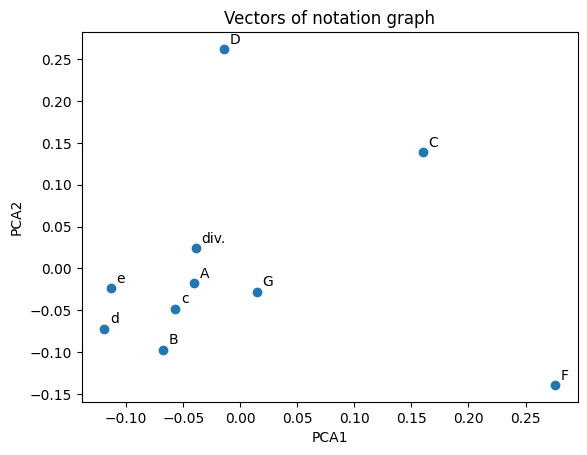

In [19]:
plt.scatter(transformed_vector['PCA1'], transformed_vector['PCA2'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Vectors of notation graph')
for i, index in enumerate(transformed_vector.index):
    plt.annotate(
        index,
        (transformed_vector['PCA1'][i], transformed_vector['PCA2'][i]),
        xytext=(4, 4),
        textcoords='offset points'
    )

In [20]:
normalised_vector.index

Index(['c', 'div.', 'C', 'e', 'd', 'D', 'G', 'A', 'B', 'F'], dtype='object')

# Collocations
What about collocations?  The idea of n-gram is meaningless here when we don't know exactly what aligns with what.  I use bag-of-words instead (n-BoW).  Here is a function that generates collocations by summing and normalising vectors.

In [21]:
# This function can be more easily vectorised and memoised, but is implemented
# simply here for clarity.
def create_collocations(vector_table, r):
    result = []
    index = []
    # All possible collocations
    n = len(vector_table.index)
    n_combs = special.comb(n, r, repetition=True)
    combs = combinations_with_replacement(vector_table.index, r)
    for comb in tqdm(combs, total=n_combs):
        # Average the vector over these rows
        new_vec = vector_table.loc[list(comb)].sum(axis=0) / r
        # It needs normalising however.
        
        # All the different ways this combination could arise
        perms = permutations(comb)
        # res = possibility of this combination arising
        res = 0
        for perm in perms:
            # Start with the permutation being definite
            perm_res = 1
            for i, j in pairwise(perm):
                # Multiply by the possibility of this particular vector
                perm_res *= (
                    vector_table.loc[i, j + '_N'] +
                    vector_table.loc[i, j + '_S']
                )
            # Add the result to the full possibility
            res += perm_res
        new_vec *= res
        result.append(new_vec)
        index.append(frozenbag(comb))
    df = pd.DataFrame(result, index=index)
    df_sum = df.sum().sum()
    return df.div(df_sum / len(df))


Let's make some 2-BoWs.

In [22]:
two_bows = create_collocations(normalised_vector, 2)
two_bows

  0%|          | 0/55.0 [00:00<?, ?it/s]

c_N    div._N  C_N       e_N       d_N       D_N       G_N  \
(c, c)        0.180222  0.131072  0.0  0.046833  0.142803  0.000000  0.119944   
(c, div.)     0.127077  0.093678  0.0  0.059862  0.128280  0.034873  0.097153   
(c, C)        0.059322  0.150639  0.0  0.015416  0.047005  0.023888  0.039481   
(c, e)        0.171095  0.072018  0.0  0.022962  0.184777  0.000000  0.092849   
(c, d)        0.306087  0.114460  0.0  0.078115  0.155403  0.000000  0.128761   
(c, D)        0.047850  0.034800  0.0  0.012434  0.037915  0.000000  0.031846   
(c, G)        0.094783  0.109530  0.0  0.021974  0.078443  0.000000  0.093632   
(c, A)        0.094304  0.072559  0.0  0.020916  0.075482  0.000000  0.130390   
(c, B)        0.221522  0.118780  0.0  0.036411  0.157907  0.000000  0.185043   
(c, F)        0.022868  0.096384  0.0  0.005942  0.018120  0.000000  0.055096   
(div., div.)  0.065506  0.049544  0.0  0.057617  0.093631  0.052746  0.062623   
(div., C)     0.064481  0.274759  0.0  0.056715  0.092166  0.102140  0.061643   
(div., e)     0.082719  0.028410  0.0  0.023620  0.111904  0.020067  0.049268   
(div., d)     0.139290  0.043055  0.0  0.054012  0.081853  0.024161  0.060447   
(div., D)     0.029003  0.021936  0.0  0.025510  0.041456  0.023353  0.027726   
(div., G)     0.065765  0.092564  0.0  0.038159  0.080288  0.031084  0.087801   
(div., A)     0.055184  0.044719  0.0  0.031533  0.065457  0.026595  0.108020   
(div., B)     0.098140  0.048324  0.0  0.031390  0.086142  0.023161  0.094896   
(div., F)     0.054240  0.406894  0.0  0.047707  0.077528  0.043674  0.234788   
(C, C)        0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
(C, e)        0.022019  0.036918  0.0  0.000648  0.029062  0.007395  0.009693   
(C, d)        0.033817  0.038843  0.0  0.008547  0.012057  0.007232  0.009828   
(C, D)        0.000000  0.074512  0.0  0.000000  0.000000  0.016558  0.000000   
(C, G)        0.007324  0.053572  0.0  0.001134  0.006771  0.008108  0.013725   
(C, A)        0.006059  0.037060  0.0  0.000679  0.004991  0.007036  0.020908   
(C, B)        0.024012  0.044089  0.0  0.002108  0.015585  0.007754  0.023327   
(C, F)        0.000000  0.018642  0.0  0.000000  0.000000  0.001416  0.006134   
(e, e)        0.012231  0.002023  0.0  0.000360  0.016143  0.000000  0.005384   
(e, d)        0.220295  0.039253  0.0  0.036535  0.161101  0.000000  0.076844   
(e, D)        0.015829  0.002619  0.0  0.000466  0.020891  0.000000  0.006968   
(e, G)        0.057191  0.038315  0.0  0.003351  0.070219  0.000000  0.044261   
(e, A)        0.055473  0.018205  0.0  0.002659  0.067039  0.000000  0.061882   
(e, B)        0.117231  0.032395  0.0  0.006936  0.114636  0.000000  0.083358   
(e, F)        0.009577  0.029440  0.0  0.000282  0.012640  0.000000  0.018144   
(d, d)        0.191901  0.035752  0.0  0.048499  0.068419  0.000000  0.055772   
(d, D)        0.033201  0.006185  0.0  0.008391  0.011837  0.000000  0.009649   
(d, G)        0.103802  0.055417  0.0  0.024588  0.046554  0.000000  0.056777   
(d, A)        0.108629  0.032142  0.0  0.025076  0.046621  0.000000  0.084956   
(d, B)        0.248113  0.065665  0.0  0.046401  0.117375  0.000000  0.139411   
(d, F)        0.031354  0.063913  0.0  0.007924  0.011179  0.000000  0.038148   
(D, D)        0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
(D, G)        0.024324  0.056750  0.0  0.003765  0.022487  0.000000  0.045582   
(D, A)        0.022557  0.020096  0.0  0.002526  0.018578  0.000000  0.077831   
(D, B)        0.026379  0.010102  0.0  0.002316  0.017121  0.000000  0.025627   
(D, F)        0.000000  0.012746  0.0  0.000000  0.000000  0.000000  0.006373   
(G, G)        0.040378  0.094204  0.0  0.006250  0.037328  0.000000  0.075666   
(G, A)        0.074750  0.121782  0.0  0.010009  0.065424  0.000000  0.197594   
(G, B)        0.126581  0.104221  0.0  0.013027  0.090030  0.000000  0.148769   
(G, F)        0.024582  0.293035  0.0  0.003805  0

The vector is still just as wide, so let's make another PCA.

In [23]:
pca = PCA(n_components=2)
transformed_vector = pd.DataFrame(
    pca.fit_transform(two_bows),
    index=two_bows.index,
    columns=['PCA1', 'PCA2']
)
transformed_vector

PCA1      PCA2
(c, c)        0.212212 -0.086168
(c, div.)     0.161226 -0.020559
(c, C)        0.055692  0.109849
(c, e)        0.155357 -0.093253
(c, d)        0.304470 -0.170006
(c, D)       -0.017410  0.055866
(c, G)        0.102147 -0.015481
(c, A)        0.110108 -0.042080
(c, B)        0.263510 -0.128653
(c, F)       -0.139741  0.014157
(div., div.)  0.044487  0.027070
(div., C)     0.381379  0.334870
(div., e)    -0.014037 -0.027815
(div., d)     0.034896 -0.056801
(div., D)     0.013260  0.108146
(div., G)     0.113709  0.038177
(div., A)     0.064021  0.006587
(div., B)     0.022324 -0.037980
(div., F)     0.281973  0.186050
(C, C)       -0.263401 -0.012660
(C, e)       -0.162710  0.021221
(C, d)       -0.165530  0.012463
(C, D)       -0.047860  0.164690
(C, G)       -0.155471  0.044528
(C, A)       -0.168436  0.030335
(C, B)       -0.158541  0.020158
(C, F)       -0.244024  0.001599
(e, e)       -0.235418 -0.019066
(e, d)        0.126352 -0.134323
(e, D)       -0.194162  0.003339
(e, G)       -0.067119 -0.022201
(e, A)       -0.068246 -0.035636
(e, B)       -0.002256 -0.079598
(e, F)       -0.219377 -0.005051
(d, d)        0.012747 -0.122129
(d, D)       -0.171512  0.000843
(d, G)       -0.017141 -0.045318
(d, A)       -0.000092 -0.065588
(d, B)        0.165870 -0.158742
(d, F)       -0.172184 -0.004228
(D, D)       -0.263401 -0.012660
(D, G)        0.079129  0.134939
(D, A)        0.074626  0.106217
(D, B)       -0.153242  0.010002
(D, F)       -0.244140 -0.000159
(G, G)        0.027485  0.028109
(G, A)        0.295809  0.024685
(G, B)        0.155157 -0.044205
(G, F)        0.100782  0.118972
(A, A)        0.001459 -0.013868
(A, B)        0.277604 -0.090892
(A, F)        0.010809  0.066048
(B, B)        0.102119 -0.116506
(B, F)       -0.141870  0.005364
(F, F)       -0.263401 -0.012660

55

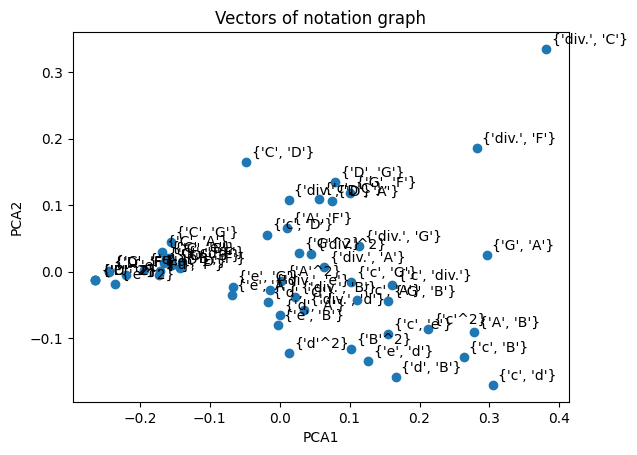

In [24]:
plt.scatter(transformed_vector['PCA1'], transformed_vector['PCA2'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Vectors of notation graph')
for i, index in enumerate(transformed_vector.index):
    plt.annotate(
        index,
        (transformed_vector['PCA1'][i], transformed_vector['PCA2'][i]),
        xytext=(4, 4),
        textcoords='offset points'
    )
len(transformed_vector)

Great, let's try with higher and higher *n*.  First, 3.

  0%|          | 0/220.0 [00:00<?, ?it/s]

CPU times: user 79.4 ms, sys: 0 ns, total: 79.4 ms
Wall time: 77.7 ms


220

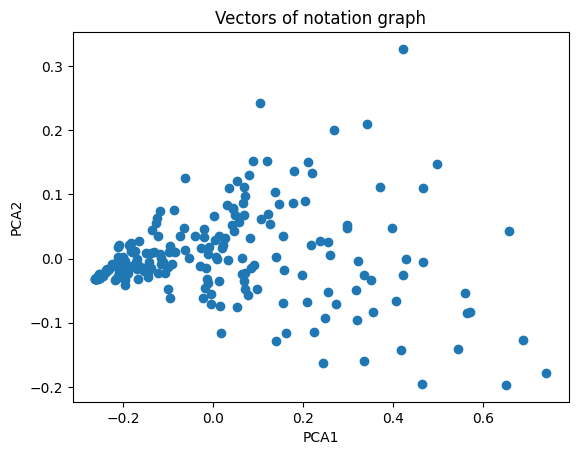

In [25]:
%%time
three_bows = create_collocations(normalised_vector, 3)
pca = PCA(n_components=2)
transformed_vector = pd.DataFrame(
    pca.fit_transform(three_bows),
    index=three_bows.index,
    columns=['PCA1', 'PCA2']
)
plt.scatter(transformed_vector['PCA1'], transformed_vector['PCA2'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Vectors of notation graph')
len(transformed_vector)

4-BoWs...

  0%|          | 0/715.0 [00:00<?, ?it/s]

CPU times: user 483 ms, sys: 10.4 ms, total: 493 ms
Wall time: 473 ms


715

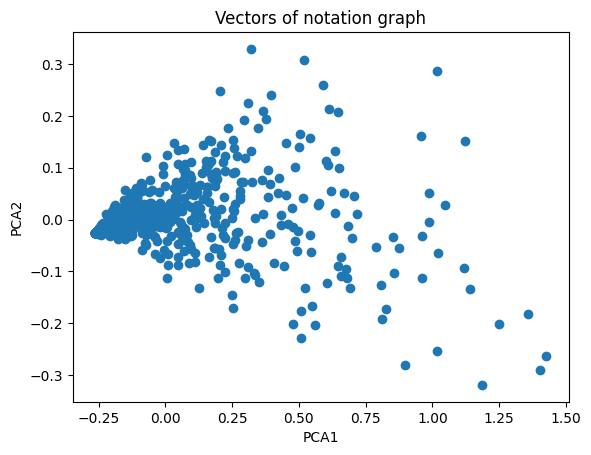

In [26]:
%%time
bows = create_collocations(normalised_vector, 4)
pca = PCA(n_components=2)
transformed_vector = pd.DataFrame(
    pca.fit_transform(bows),
    index=bows.index,
    columns=['PCA1', 'PCA2']
)
plt.scatter(transformed_vector['PCA1'], transformed_vector['PCA2'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Vectors of notation graph')
len(transformed_vector)

5-BoWs...

  0%|          | 0/2002.0 [00:00<?, ?it/s]

CPU times: user 5.89 s, sys: 83.1 ms, total: 5.97 s
Wall time: 5.87 s


2002

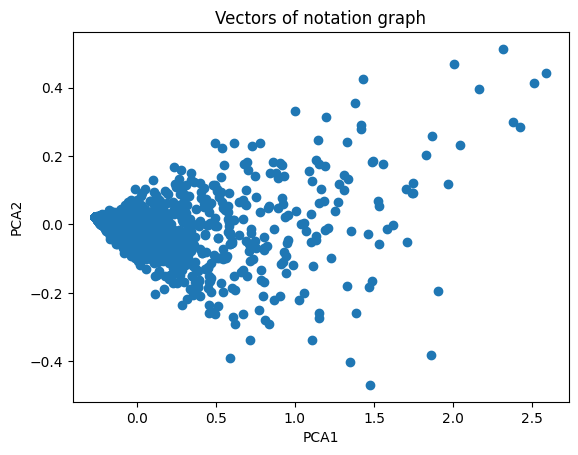

In [27]:
%%time
bows = create_collocations(normalised_vector, 5)
pca = PCA(n_components=2)
transformed_vector = pd.DataFrame(
    pca.fit_transform(bows),
    index=bows.index,
    columns=['PCA1', 'PCA2']
)
plt.scatter(transformed_vector['PCA1'], transformed_vector['PCA2'])
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Vectors of notation graph')
len(transformed_vector)

# Anomaly extraction
As can be seen above, the time taken to generate n-BoWs increases as the algorithm is at least O(n!) due to the combinations and permutations required.  Moreover, for 5-BoWs on such a small example, over 2,000 samples were created.  We need to have a way of slimming these down to extract only the most interesting samples, the ones off from the main cluster.  We can do this using a one-class support vector machine (SVM).

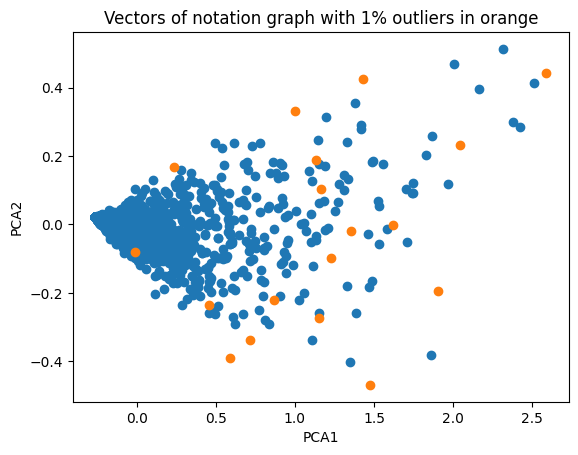

In [28]:
outlier_fraction = 0.01

discriminator = OneClassSVM(nu=outlier_fraction, kernel='rbf')
y_pred = discriminator.fit(bows.values).predict(bows.values)
plt.scatter(
    transformed_vector[y_pred == 1]['PCA1'],
    transformed_vector[y_pred == 1]['PCA2']
)
plt.scatter(
    transformed_vector[y_pred == -1]['PCA1'],
    transformed_vector[y_pred == -1]['PCA2']
)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Vectors of notation graph with 1% outliers in orange')
transformed_vector[y_pred == -1].to_csv('5BoW-outliers.d', sep="\t")

In [29]:
print(f"PCA plot explains {np.sum(pca.explained_variance_) * 100:.2f}% variance")

PCA plot explains 15.82% variance


Some of these don't look anomalous, but that is because they are anomalous only in the higher dimension of the node vector -- this doesn't necessarily come across in the PCA plot.

What are these anomalous BoWs?

In [30]:
transformed_vector[y_pred == -1].index

Index([         ('c', 'c', 'c', 'c', 'c'),    ('c', 'c', 'c', 'div.', 'div.'),
                ('c', 'c', 'c', 'd', 'B'),    ('c', 'c', 'div.', 'div.', 'C'),
                ('c', 'c', 'd', 'd', 'd'),          ('c', 'd', 'd', 'd', 'B'),
                ('c', 'B', 'B', 'B', 'B'), ('div.', 'div.', 'div.', 'C', 'C'),
                ('d', 'd', 'd', 'd', 'B'),          ('D', 'G', 'G', 'A', 'A'),
                ('G', 'G', 'G', 'A', 'A'),          ('G', 'G', 'G', 'A', 'B'),
                ('G', 'G', 'G', 'A', 'F'),          ('G', 'G', 'A', 'F', 'F'),
                ('G', 'A', 'A', 'B', 'B'),          ('A', 'A', 'A', 'B', 'B'),
                ('A', 'A', 'B', 'B', 'B'),          ('A', 'B', 'B', 'B', 'B')],
      dtype='object')

Of course, none of these BoWs are expressed in the graph, but what we can conclude from this is that such BoWs, if they were to appear, could reasonably be classed as anomalous.  We also have a model to say, given a certain collocation, does it belong to the set?

# Putting it all together
Below is a function that creates the matrix from a list of voice 1, voice 2, S links and adds 0-weight links for any missing elements for future comparisons.

In [31]:
def make_matrix(v_1, v_2, S_links, missing_elements):
    G = nx.MultiDiGraph()
    _ = G.add_edges_from(
        (
            (f"v1_{a}_{i}", f"v1_{b}_{i+1}") for i, (a, b) in enumerate(
                pairwise(v_1)
            )
        ), weight=1, key=N_KEY)
    _ = G.add_edges_from(
        (
            (f"v2_{a}_{i}", f"v2_{b}_{i+1}") for i, (a, b) in enumerate(
                pairwise(v_2)
            )
        ), weight=1, key=N_KEY)
    for v1i, v2i, weight in S_links:
        G.add_edge(
            f"v1_{v_1[v1i]}_{v1i}", f"v2_{v_2[v2i]}_{v2i}",
            weight=1, key=S_KEY
        )
        G.add_edge(
            f"v2_{v_2[v2i]}_{v2i}", f"v1_{v_1[v1i]}_{v1i}",
            weight=1, key=S_KEY
        )
    has_seq_in = {v for u, v, k in filter(
        lambda x: x[2] == N_KEY,
        G.edges(keys=True)
    )}
    start_nodes = set(filter(lambda x: x not in has_seq_in, G.nodes()))
    linkLayers(G, start_nodes)
    condensed_G = nx.MultiDiGraph()
    regex = r'v\d_([^_]+)_\d'
    for u, v, mode, weight in G.edges(keys=True, data='weight'):
        match = re.search(regex, u)
        if not match:
            continue
        unique_u = match.group(1)
        match = re.search(regex, v)
        if not match:
            continue
        unique_v = match.group(1)
        if condensed_G.has_edge(unique_u, unique_v, key=mode):
            weight += condensed_G[unique_u][unique_v][mode]['weight']
        condensed_G.add_edge(unique_u, unique_v, key=mode, weight=weight)
    for el in missing_elements:
        condensed_G_nodes = list(condensed_G.nodes)
        condensed_G.add_edges_from(((u, el, N_KEY) for u in condensed_G_nodes), weight=0)
        condensed_G.add_edges_from(((el, v, N_KEY) for v in condensed_G_nodes), weight=0)
        condensed_G.add_edges_from(((u, el, S_KEY) for u in condensed_G_nodes), weight=0)
        condensed_G.add_edges_from(((el, v, S_KEY) for v in condensed_G_nodes), weight=0)
    G_N_graph = condensed_G.edge_subgraph(
        (u, v, k) for u, v, k in condensed_G.edges(keys=True) if k == N_KEY
    )
    G_S_graph = condensed_G.edge_subgraph(
        (u, v, k) for u, v, k in condensed_G.edges(keys=True) if k == S_KEY
    )
    G_N_vector = pd.DataFrame(
        nx.to_numpy_array(G_N_graph),
        columns=(str(x) + '_N' for x in G_N_graph.nodes()),
        index=G_N_graph.nodes()
    )
    G_S_vector = pd.DataFrame(
        nx.to_numpy_array(G_S_graph),
        columns=(str(x) + '_S' for x in G_S_graph.nodes()),
        index=G_S_graph.nodes()
    )
    G_wide_vector = pd.concat([G_N_vector, G_S_vector], axis=1)
    G_normalised_vector = G_wide_vector.apply(lambda row: row / (row.sum() or 1), axis=1)
    return G_normalised_vector

# Evaluation
Let's add the next sections and see how the plot compares.  First make matrices for each section.

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

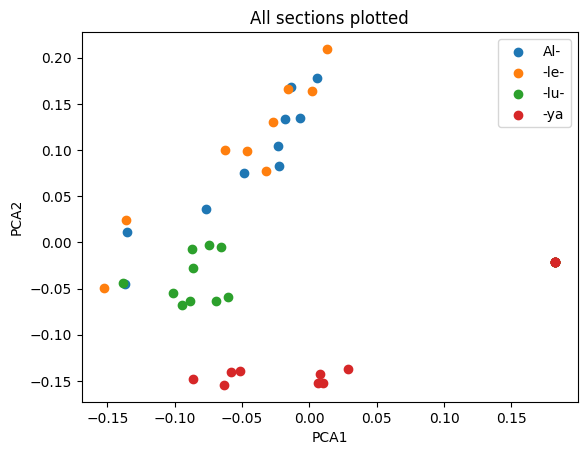

In [32]:
# First the original
v_1 = ['c', 'div.', 'e', 'd', 'c', 'B', 'c', 'c', 'B', 'G', 'G', 'div.', 'A',
       'B', 'c', 'd', 'B', 'd', 'c', 'c', 'div.', 'd', 'e', 'd', 'c', 'B',
       'A', 'G', 'A', 'B', 'B', 'A', 'G', 'F', 'div.', 'G', 'A'
      ]
v_2 = ['C', 'div.', 'div.', 'D']
S_links = [(0, 0, 1), (35, 3, 0.5), (36, 3, 0.5)]
Al_matrix = make_matrix(v_1, v_2, S_links, ['E', 'B-'])
# Then LE
v_1 = [
    'G', 'A', 'div.', 'd', 'c', 'B', 'd', 'c', 'A', 'div.', 'd', 'd', 'e', 'd',
    'c', 'B', 'A', 'G', 'A', 'B', 'c', 'c', 'B', 'A', 'div.', 'B'
]
v_2 = ['D', 'div.', 'div.', 'E']
S_links = [(0, 0, 1), (25, 3, 1)]
Le_matrix = make_matrix(v_1, v_2, S_links, ['F', 'C', 'B-'])
Le_matrix = Le_matrix[Al_matrix.columns]
# Then LU
v_1 = [
    'B', 'div.', 'e', 'd', 'c', 'B', 'd', 'd', 'B', 'A', 'div.', 'e', 'd', 'e', 'e',
    'd', 'c', 'B', 'A', 'div.', 'B-', 'A', 'B-', 'B-', 'A', 'G', 'F', 'F', 'div.',
    'G', 'A', 'B-', 'c', 'A', 'B-', 'G', 'A', 'F', 'div.', 'G', 'A', 'B-', 'A', 'G',
    'F', 'E', 'D', 'G', 'div.', 'A'
]
v_2 = [
    'E', 'div.', 'D', 'div.', 'A', 'div.', 'B-', 'div.', 'div.', 'A'
]
# There is a disagreement between Everist and Tischler/Waite.  Tischler/Waite
# align the tenor A with the e in the organal voice, but Everist with the A
# in the organal voice.
S_links = [(0, 0, 1), (9, 2, 1), (11, 4, 0.5), (18, 4, 0.5), (20, 6, 1), (49, 9, 1)]
Lu_matrix = make_matrix(v_1, v_2, S_links, ['C', 'D'])
Lu_matrix = Lu_matrix[Al_matrix.columns]
# Finally YA
v_1 = [
    'A', 'A', 'B-', 'div.', 'D', 'E', 'F', 'E', 'F', 'F', 'E', 'D', 'C', 'D', 'E',
    'G', 'div.', 'A', 'B-', 'A', 'G', 'F', 'E', 'D', 'E', 'F', 'A', 'G'
]
v_2 = [
    'A', 'div.', 'G', 'div.'
]
S_links = [(0, 0, 1), (15, 2, 1)]
Ya_matrix = make_matrix(v_1, v_2, S_links, ['B', 'c', 'd', 'e'])
Ya_matrix = Ya_matrix[Al_matrix.columns]

pca = PCA(n_components=2)
pca.fit(pd.concat([Al_matrix, Le_matrix, Lu_matrix, Ya_matrix]))

def do_transform(pca, vec):
    return pd.DataFrame(
        pca.transform(vec),
        index=vec.index,
        columns=['PCA1', 'PCA2']
    )

Al_transformed = do_transform(pca, Al_matrix)
Le_transformed = do_transform(pca, Le_matrix)
Lu_transformed = do_transform(pca, Lu_matrix)
Ya_transformed = do_transform(pca, Ya_matrix)

fig, ax = plt.subplots()

ax.scatter(
    Al_transformed['PCA1'],
    Al_transformed['PCA2'],
    label="Al-",
)
ax.scatter(
    Le_transformed['PCA1'],
    Le_transformed['PCA2'],
    label="-le-",
)
ax.scatter(
    Lu_transformed['PCA1'],
    Lu_transformed['PCA2'],
    label="-lu-",
)
ax.scatter(
    Ya_transformed['PCA1'],
    Ya_transformed['PCA2'],
    label="-ya",
)
ax.legend()
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_title('All sections plotted')
plt.show()

Then we can plot collocations.  Here we're using 5-BoWs.

Making Al_bows


  0%|          | 0/4368.0 [00:00<?, ?it/s]

Making Le_bows


  0%|          | 0/4368.0 [00:00<?, ?it/s]

Making Lu_bows


  0%|          | 0/4368.0 [00:00<?, ?it/s]

Making Ya_bows


  0%|          | 0/4368.0 [00:00<?, ?it/s]

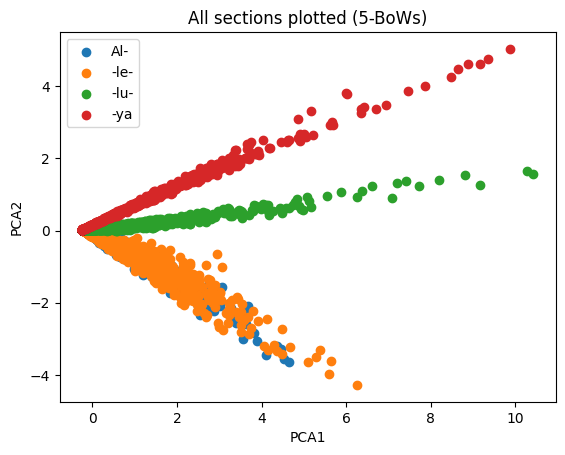

In [33]:
print("Making Al_bows", flush=True)
Al_bows = create_collocations(Al_matrix, 5)
print("Making Le_bows", flush=True)
Le_bows = create_collocations(Le_matrix, 5)
print("Making Lu_bows", flush=True)
Lu_bows = create_collocations(Lu_matrix, 5)
print("Making Ya_bows", flush=True)
Ya_bows = create_collocations(Ya_matrix, 5)

pca = PCA(n_components=2)
pca.fit(pd.concat([Al_bows, Le_bows, Lu_bows, Ya_bows]))

Al_transformed = do_transform(pca, Al_bows)
Le_transformed = do_transform(pca, Le_bows)
Lu_transformed = do_transform(pca, Lu_bows)
Ya_transformed = do_transform(pca, Ya_bows)

fig, ax = plt.subplots()

ax.scatter(
    Al_transformed['PCA1'],
    Al_transformed['PCA2'],
    label="Al-",
)
ax.scatter(
    Le_transformed['PCA1'],
    Le_transformed['PCA2'],
    label="-le-",
)
ax.scatter(
    Lu_transformed['PCA1'],
    Lu_transformed['PCA2'],
    label="-lu-",
)
ax.scatter(
    Ya_transformed['PCA1'],
    Ya_transformed['PCA2'],
    label="-ya",
)
ax.legend()
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_title('All sections plotted (5-BoWs)')
plt.show()

We can then use our favourite classifier to predict classes.

In [34]:
X = pd.concat([Al_bows, Le_bows, Lu_bows, Ya_bows])
y = pd.DataFrame(
    chain.from_iterable(
        repeat(i, len(x)) for i, x in enumerate(
            [Al_bows, Le_bows, Lu_bows, Ya_bows]
        )
    ),
    columns=['Category']
)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe = make_pipeline(StandardScaler(), PowerTransformer(), GaussianNB(var_smoothing=1e-12))
pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('powertransformer', PowerTransformer()),
                ('gaussiannb', GaussianNB(var_smoothing=1e-12))])

In [36]:
y_pred = pipe.predict(X_test)
pd.DataFrame(np.array(precision_recall_fscore_support(y_test, y_pred)).T, index=['Al', 'Le', 'Lu', 'Ya'], columns=['Precision', 'Recall', 'Fscore', 'Support'])

Precision    Recall    Fscore  Support
Al   1.000000  0.481570  0.650080    841.0
Le   1.000000  0.275824  0.432386    910.0
Lu   1.000000  0.443169  0.614161    871.0
Ya   0.355891  1.000000  0.524955    873.0

The results aren't very good.  This is because many of the results are clustered together (at the 0, 0 in the PCA plot).  We can improve this by using a one-class SVM to extract the outliers and only classify based on these.  Let's use 

In [72]:
discriminator = OneClassSVM(nu=0.5, kernel='rbf')

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=0)

y_train_pred = discriminator.fit_predict(X_train.values)
y_test_pred = discriminator.fit_predict(X_test.values)

X_train_filtered = X_train[y_train_pred == -1]
y_train_filtered = y_train[y_train_pred == -1]

X_test_filtered = X_test[y_test_pred == -1]
y_test_filtered = y_test[y_test_pred == -1]

pipe = make_pipeline(StandardScaler(), PowerTransformer(), GaussianNB())
pipe.fit(X_train_filtered, y_train_filtered.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('powertransformer', PowerTransformer()),
                ('gaussiannb', GaussianNB())])

In [74]:
y_pred = pipe.predict(X_test_filtered)
pd.DataFrame(np.array(precision_recall_fscore_support(y_test_filtered, y_pred)).T, index=['Al', 'Le', 'Lu', 'Ya'], columns=['Precision', 'Recall', 'Fscore', 'Support'])

Precision  Recall  Fscore  Support
Al        1.0     1.0     1.0     97.0
Le        1.0     1.0     1.0     88.0
Lu        1.0     1.0     1.0     83.0
Ya        1.0     1.0     1.0    101.0

Much better!